In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from lxml import etree
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import figure
from matplotlib.patches import Rectangle
import glob
import torch
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import warnings 
warnings.filterwarnings('ignore')
import time

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)
])

train_ds = datasets.MNIST(
    'data',
    train = True,
    transform=transform,
    download=True
)

train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True
)

In [15]:
#定义生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28*1),
            nn.Tanh()
        )
    def forward(self,x):
        img = self.main(x)
        img = img.view(-1,28,28,1)
        return img

In [16]:
test_data = torch.randn(4,100)

In [17]:
model = Generator()

In [18]:
res = model(test_data)

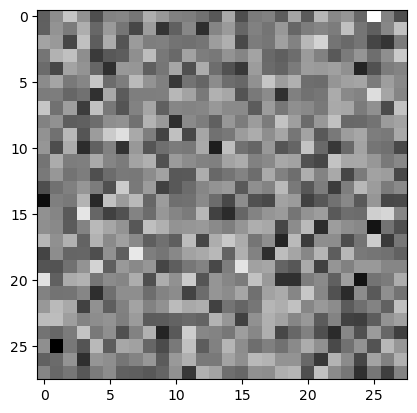

In [19]:
plt.imshow(res[0].detach().numpy(),cmap='gray')

In [20]:
# 定义判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28*1,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x = x.view(-1,28*28*1)
        x = self.main(x)
        return x

In [23]:
gen = Generator()#实例化生成器
dis = Discriminator()#实例化判别器
loss_fn = nn.BCELoss()#损失函数
g_optimizer = torch.optim.Adam(gen.parameters(),lr=0.0001)#生成器优化器
d_optimizer = torch.optim.Adam(dis.parameters(),lr=0.0001)#判别器优化器
test_seed = torch.randn(16,100)

In [26]:
def generate_and_save_image(model,epoch,test_input):
    predictions = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i]+1)/2,cmap='gray')
        plt.axis('off')
    plt.savefig('image_epoch_{}.png'.format(epoch))
    plt.show()

Epoch: 0


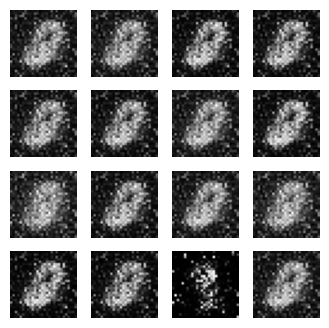

Epoch: 1


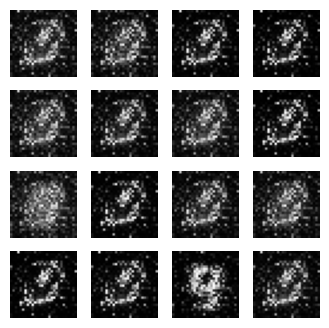

Epoch: 2


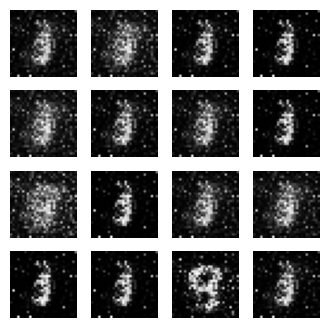

Epoch: 3


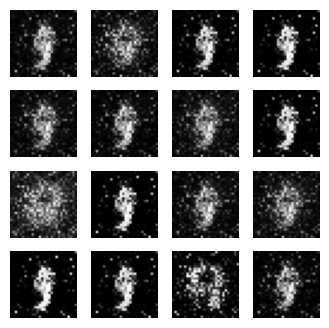

Epoch: 4


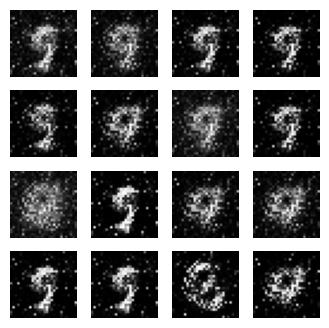

Epoch: 5


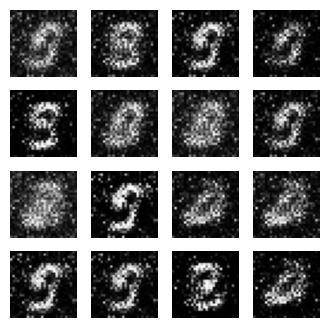

Epoch: 6


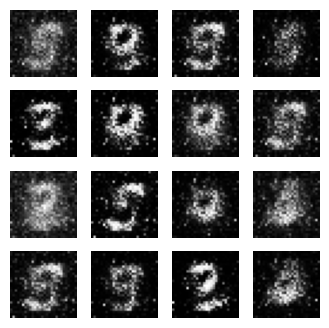

Epoch: 7


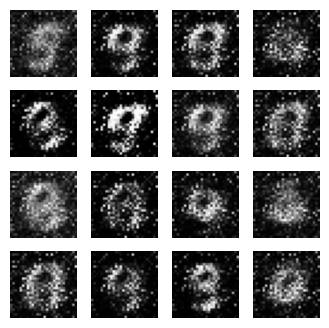

Epoch: 8


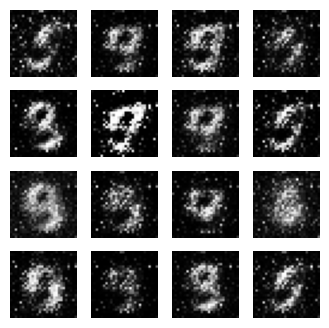

Epoch: 9


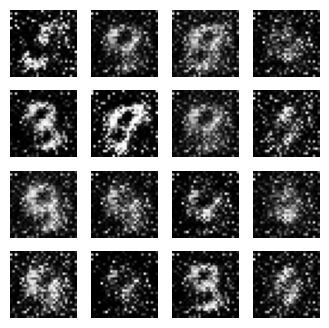

Epoch: 10


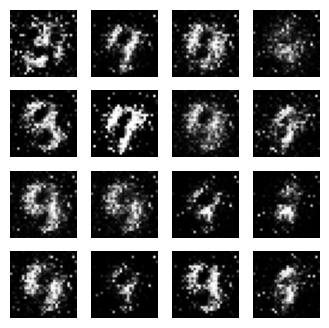

Epoch: 11


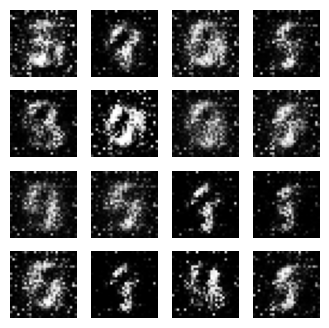

Epoch: 12


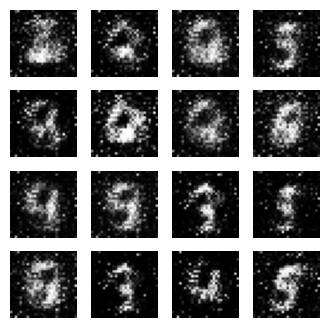

Epoch: 13


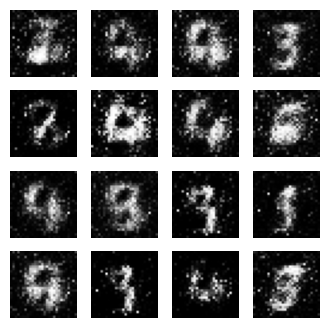

Epoch: 14


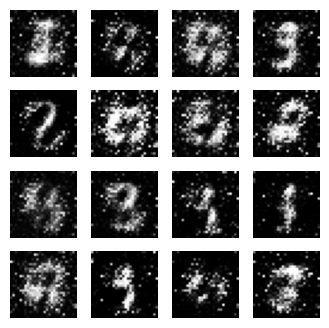

Epoch: 15


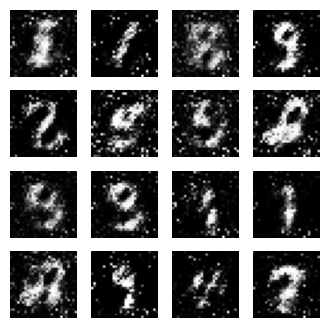

Epoch: 16


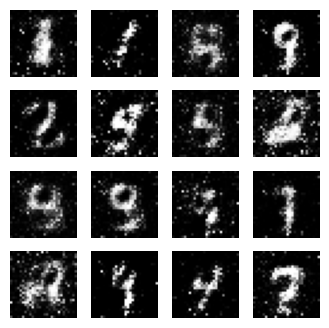

Epoch: 17


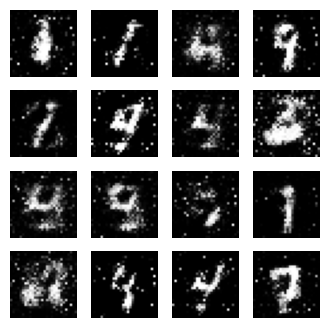

Epoch: 18


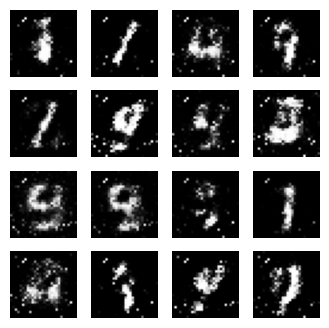

Epoch: 19


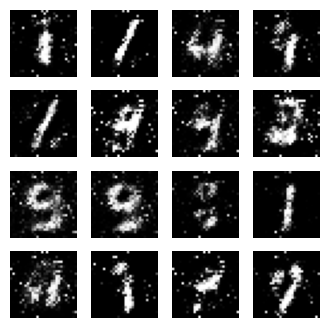

Epoch: 20


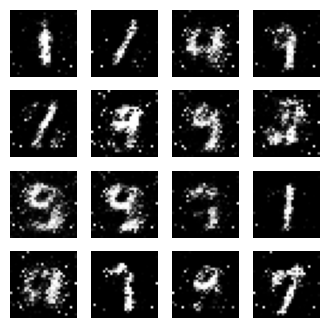

Epoch: 21


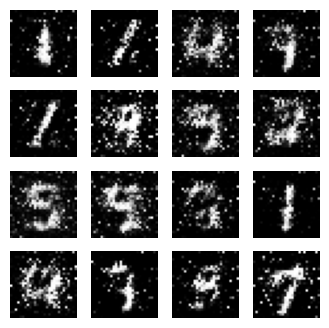

Epoch: 22


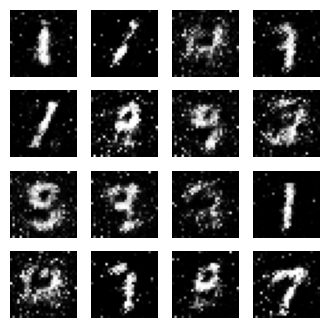

Epoch: 23


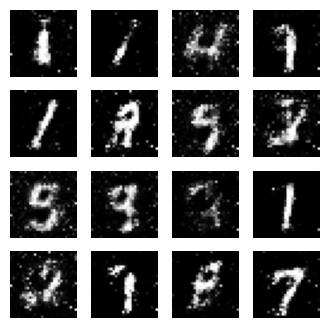

Epoch: 24


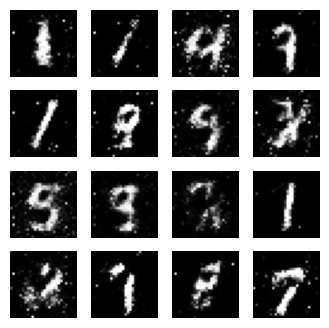

Epoch: 25


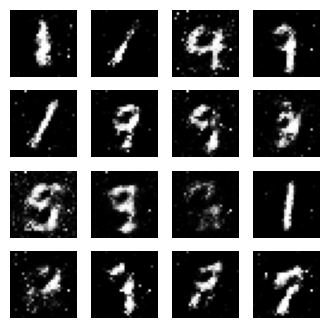

Epoch: 26


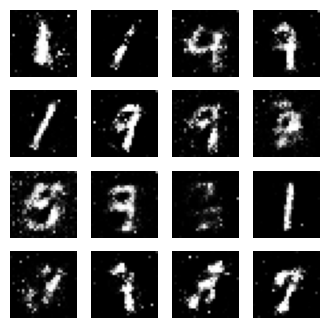

Epoch: 27


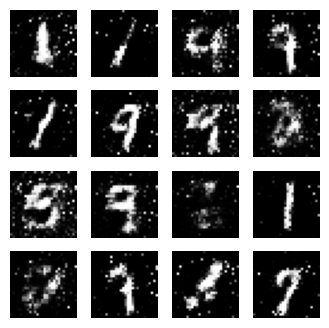

Epoch: 28


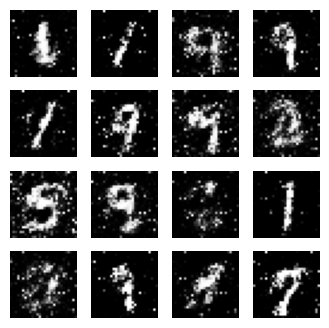

Epoch: 29


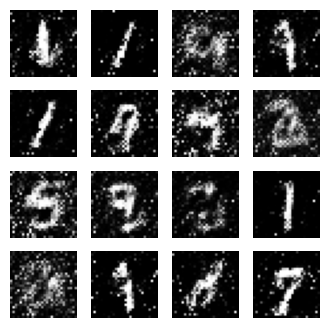

Epoch: 30


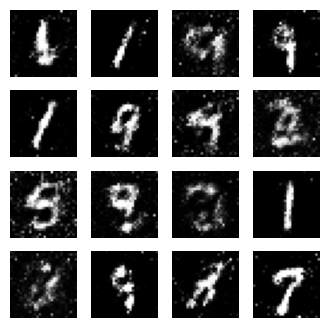

Epoch: 31


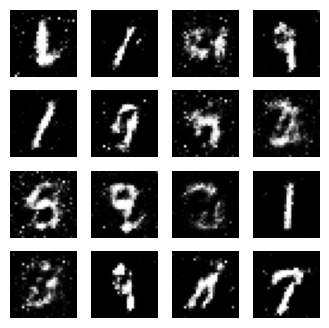

Epoch: 32


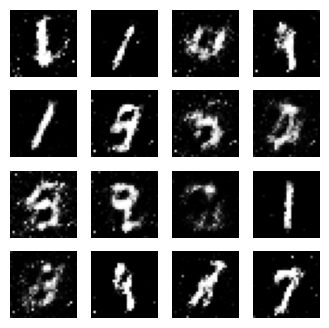

Epoch: 33


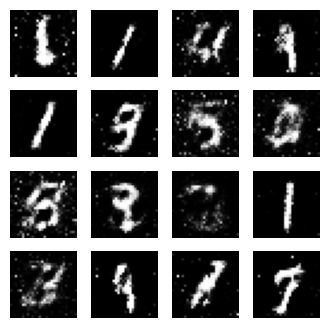

Epoch: 34


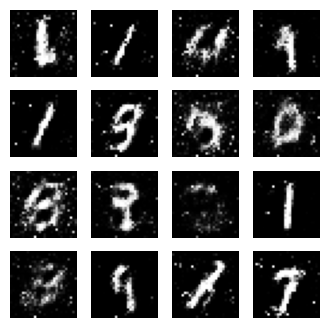

Epoch: 35


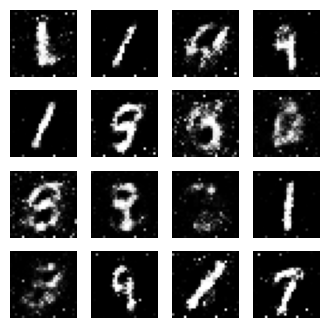

Epoch: 36


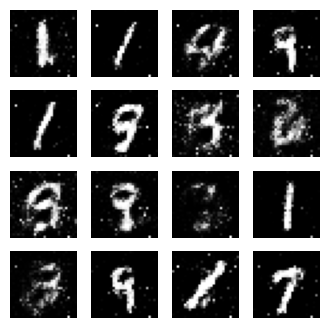

Epoch: 37


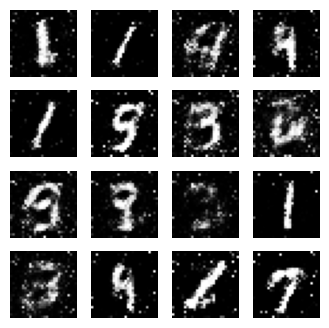

Epoch: 38


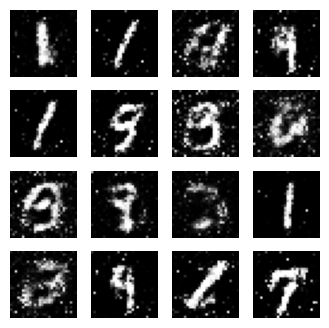

Epoch: 39


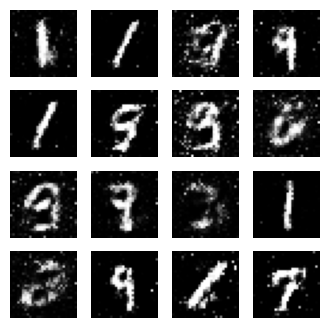

Epoch: 40


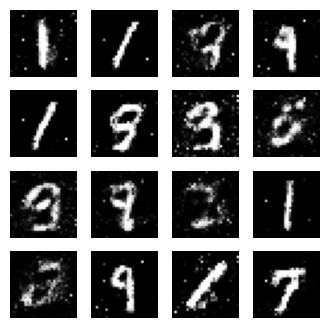

Epoch: 41


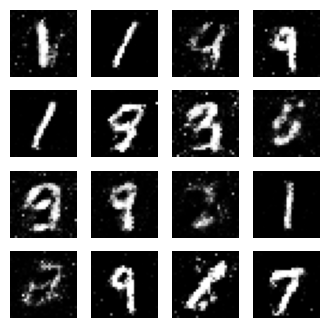

Epoch: 42


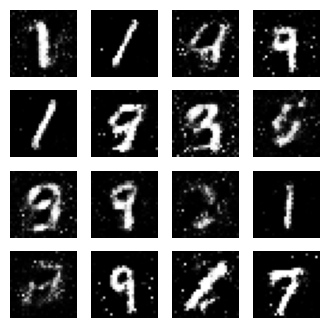

Epoch: 43


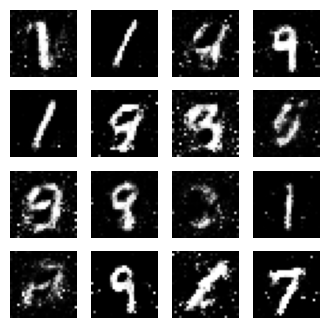

Epoch: 44


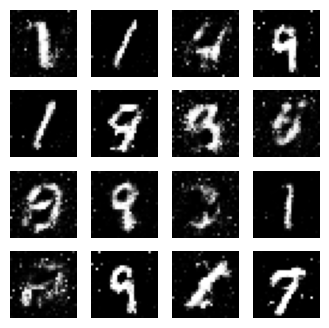

Epoch: 45


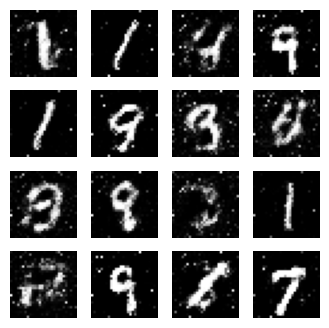

Epoch: 46


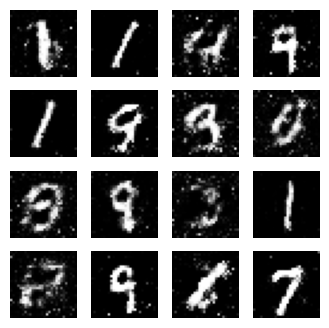

Epoch: 47


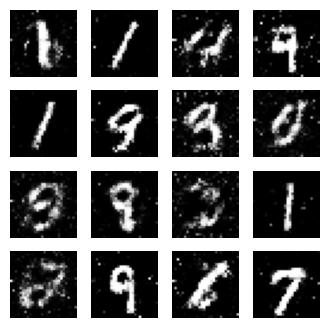

Epoch: 48


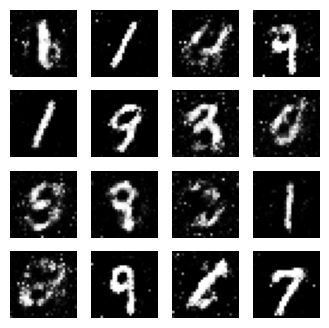

Epoch: 49


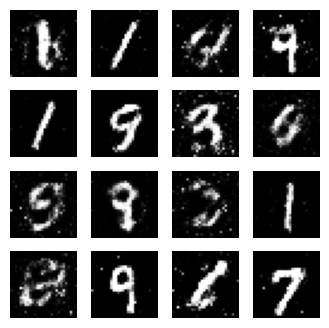

Epoch: 50


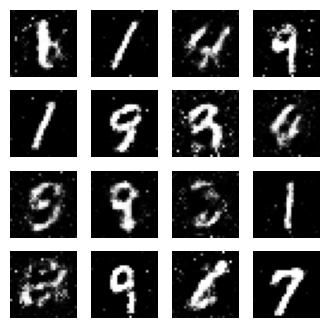

Epoch: 51


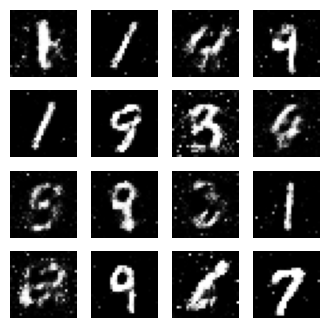

Epoch: 52


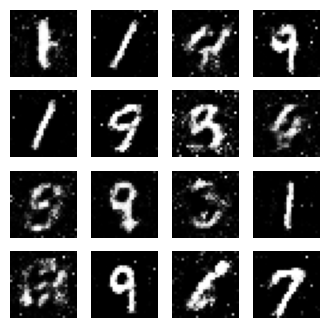

Epoch: 53


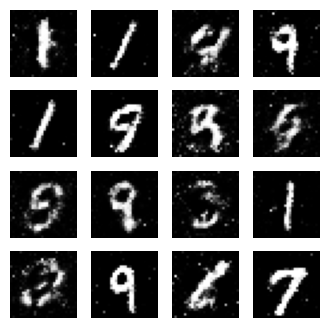

Epoch: 54


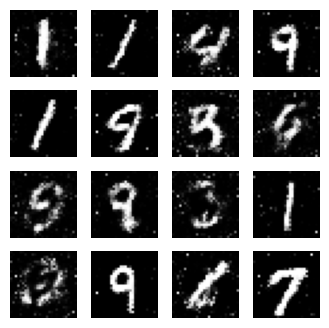

Epoch: 55


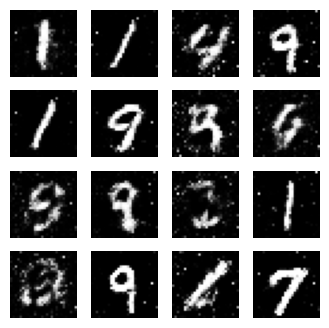

Epoch: 56


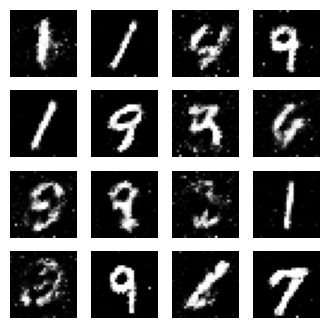

Epoch: 57


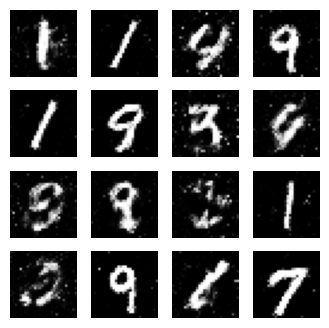

Epoch: 58


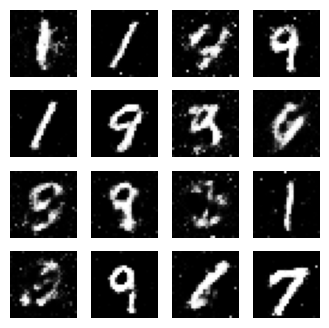

Epoch: 59


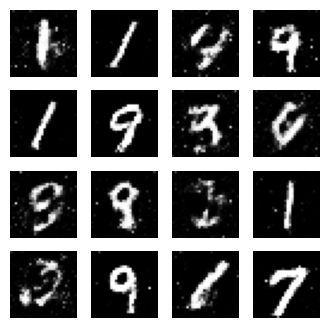

Epoch: 60


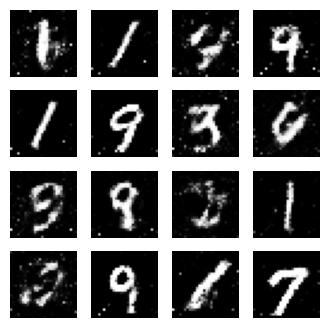

Epoch: 61


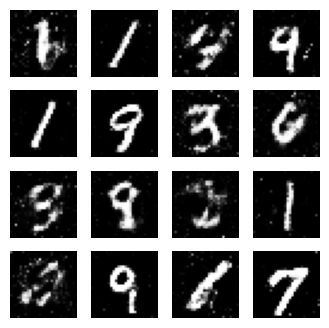

Epoch: 62


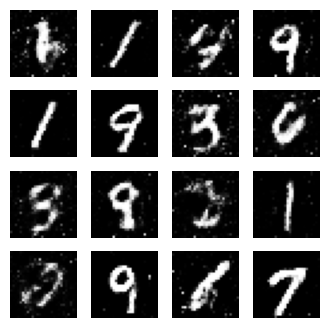

Epoch: 63


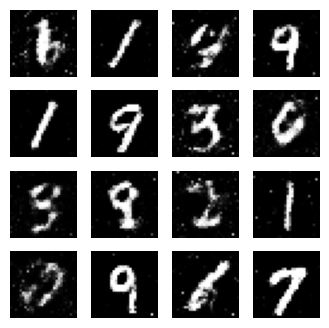

Epoch: 64


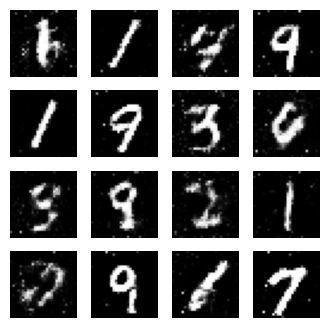

Epoch: 65


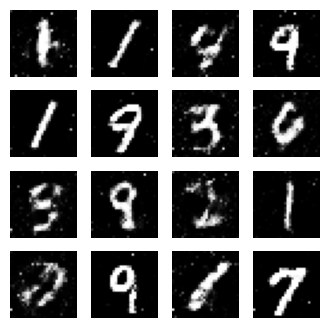

Epoch: 66


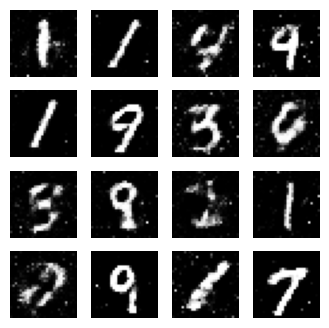

Epoch: 67


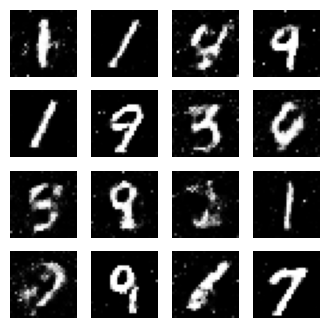

Epoch: 68


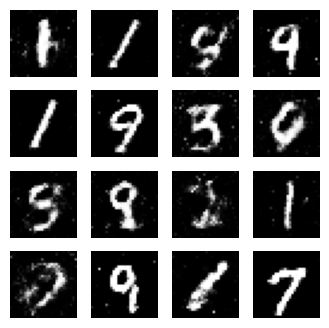

Epoch: 69


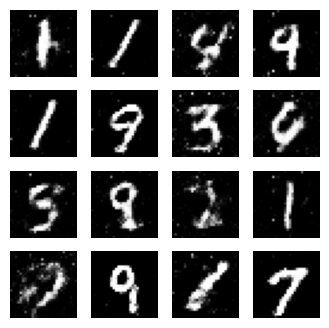

Epoch: 70


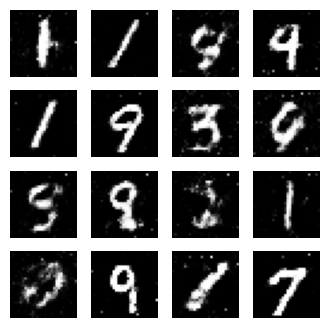

Epoch: 71


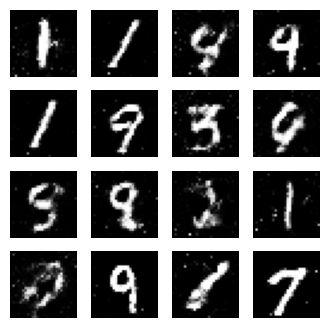

Epoch: 72


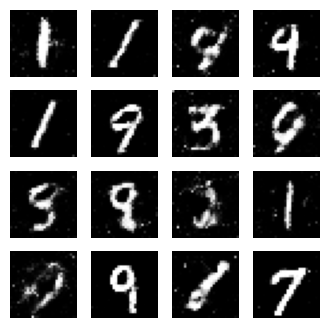

Epoch: 73


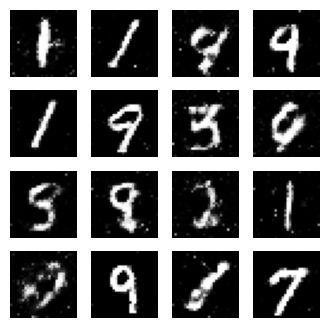

Epoch: 74


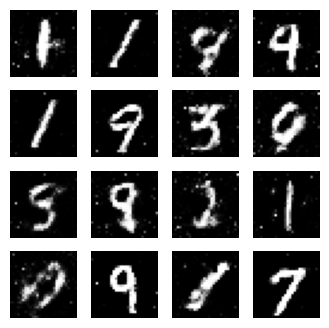

Epoch: 75


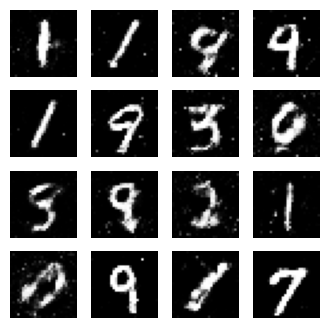

Epoch: 76


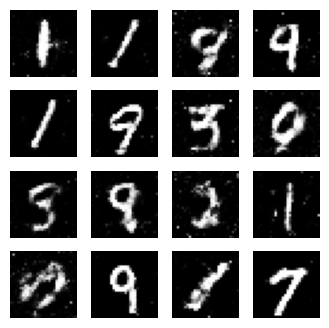

Epoch: 77


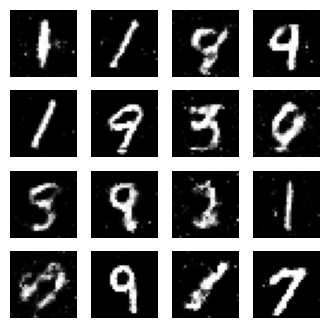

Epoch: 78


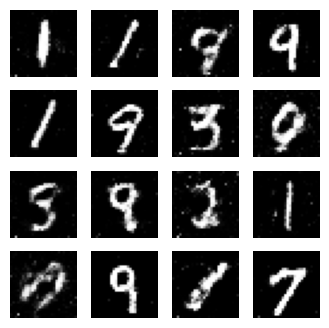

Epoch: 79


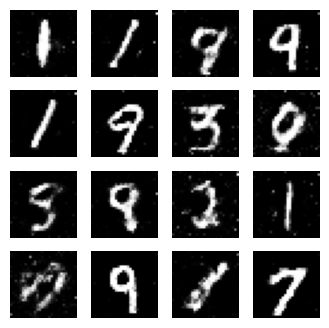

Epoch: 80


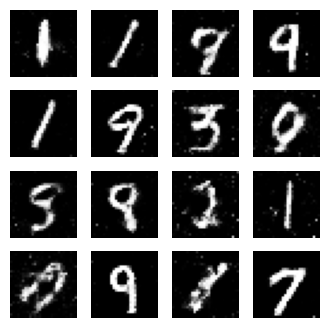

Epoch: 81


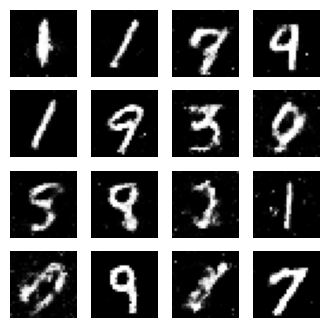

Epoch: 82


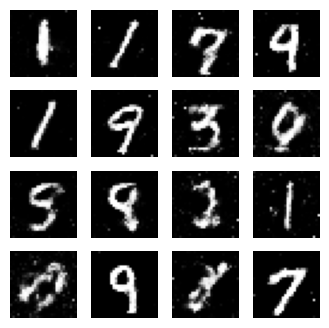

Epoch: 83


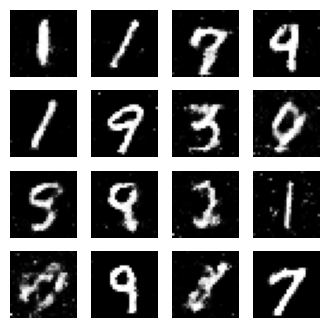

Epoch: 84


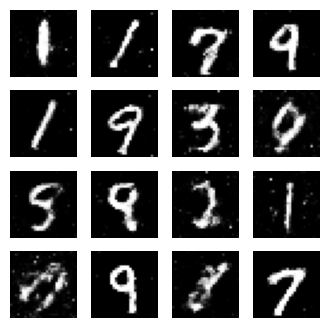

Epoch: 85


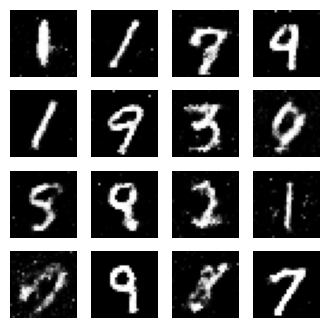

Epoch: 86


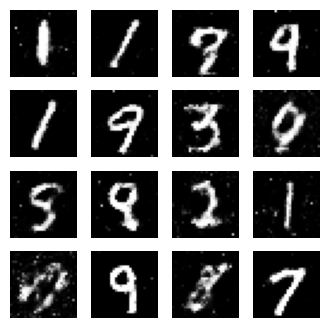

Epoch: 87


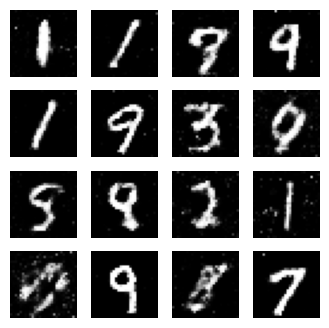

Epoch: 88


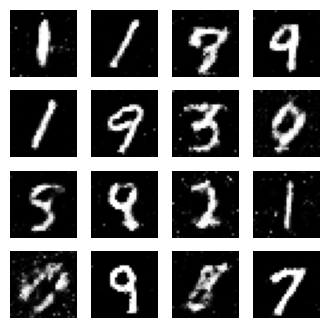

Epoch: 89


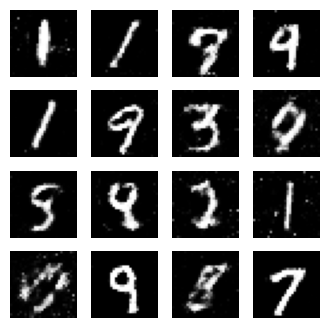

Epoch: 90


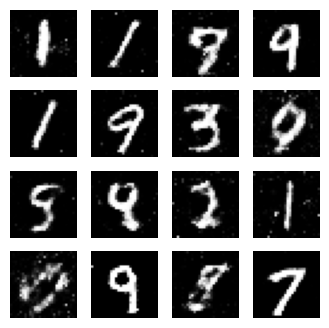

Epoch: 91


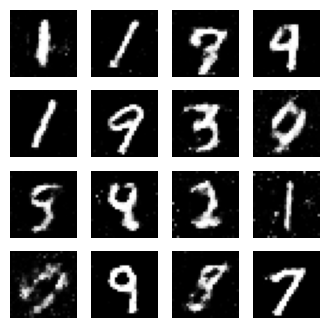

Epoch: 92


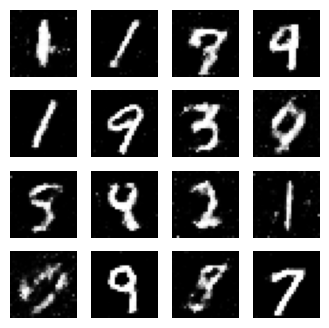

Epoch: 93


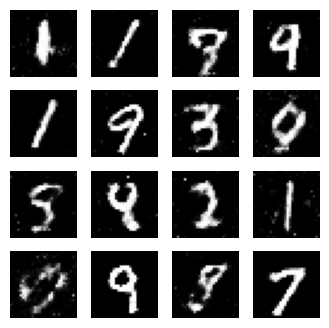

Epoch: 94


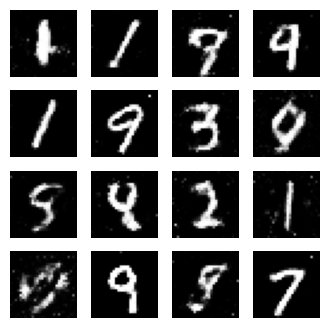

Epoch: 95


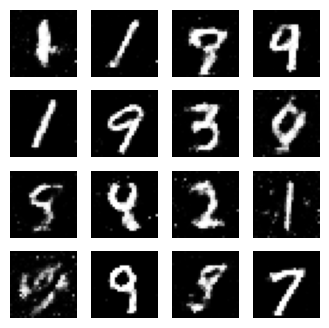

Epoch: 96


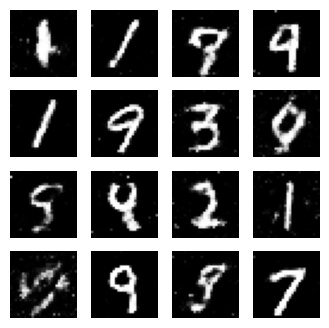

Epoch: 97


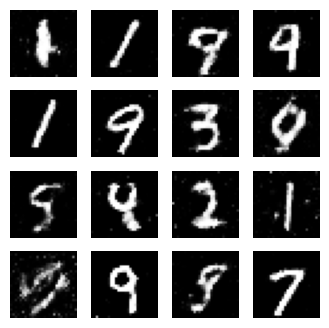

Epoch: 98


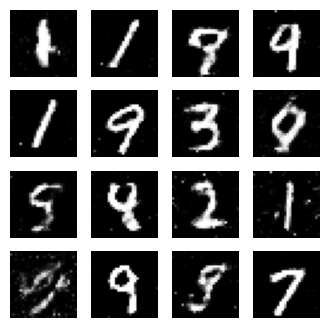

Epoch: 99


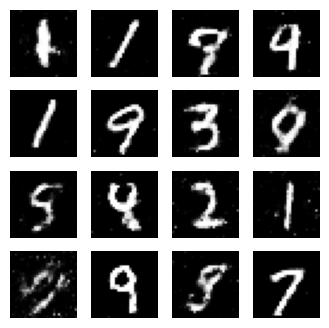

In [28]:
D_loss =[]#记录训练过程判别器损失变化
G_loss =[]#记录训练过程生成器损失变化
epochs = 100
#训练环节
for epoch in range(epochs):
    D_epoch_loss = 0   #用于累加一个epoch中的D的损失
    G_epoch_loss = 0   #用于累加一个epoch中的G的损失
    count = len(train_dl)   #共计的batch数量
    for step,(img,_) in enumerate(train_dl):
        size = img.shape[0]  #获取bath大小
        random_seed = torch.randn(size,100)
        
        #第一部分 真实图片的判定
        d_optimizer.zero_grad()
        real_output = dis(img)
        d_real_loss = loss_fn(real_output,torch.ones_like(real_output))
        d_real_loss.backward()
        
        generated_img = gen(random_seed)
        fake_ouput = dis(generated_img.detach())
        d_fake_loss = loss_fn(fake_ouput,torch.zeros_like(fake_ouput))
        d_fake_loss.backward()
        
        disc_loss = d_real_loss+d_fake_loss
        d_optimizer.step()
        
        ###判别器损失值end###
        
        
        ###生成器损失值###
        g_optimizer.zero_grad()
        fake_ouput = dis(generated_img)
        gen_loss = loss_fn(fake_ouput,torch.ones_like(fake_ouput))
        gen_loss.backward()
        g_optimizer.step()
        
        with torch.no_grad():
            D_epoch_loss+=disc_loss
            G_epoch_loss+= gen_loss
    with torch.no_grad():
        D_epoch_loss/=count
        G_epoch_loss/=count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        print('Epoch:',epoch)
        generate_and_save_image(gen,epoch,test_seed)